<div >
<img src = "figs/ans_banner_1920x200.png" />
</div>

# Caso-taller: Identificando  Burger Master con MMG

El Burger Master es un evento creado en el 2016 por el *influencer* Tulio Zuluaga, más conocido en redes como Tulio recomienda, el cual busca que por una semana las hamburgueserías de cada ciudad ofrezcan su mejor producto a un precio reducido. 

El evento ha venido creciendo y en el 2022 se extendió por 21 ciudades de Colombia para las cuales se estimó que se vendieron más de dos millones de hamburguesas. El objetivo del presente caso-taller  es identificar los puntos calientes de hamburgueserías  que compitieron en  la ciudad de Bogotá aplicando el Modelo de Mezclas Gaussianas.

## Instrucciones generales

1. Para desarrollar el *cuaderno* primero debe descargarlo.

2. Para responder cada inciso deberá utilizar el espacio debidamente especificado.

3. La actividad será calificada sólo si sube el *cuaderno* de jupyter notebook con extensión `.ipynb` en la actividad designada como "entrega calificada por el personal".

4. El archivo entregado debe poder ser ejecutado localmente por el tutor. Sea cuidadoso con la especificación de la ubicación de los archivos de soporte, guarde la carpeta de datos en el mismo `path` de su cuaderno, por ejemplo: `data`.

## Desarrollo

### 1. Carga de datos  

En la carpeta `data` se encuentra el archivo `burger_master.xlsx` para la ciudad de Bogotá, cargue estos datos en su *cuaderno* y reporte brevemente el contenido de la base.

In [1]:
# Utilice este espacio para escribir el código.

import pandas as pd
import seaborn as sns
burger_master = pd.read_excel("data/burger_master.xlsx")

In [2]:
burger_master.head()

,Restaurante,Dirección,Descripción,Latitud,Longitud
0,MAIKKI,Cra 75 # 24D – 48,"<p>MAIKKI MACUIRA: Cama de chicharrón soplado,...",4.668833,-74.116828
1,MAIKKI,Calle 119 # 11A – 24,"<p>MAIKKI MACUIRA: Cama de chicharrón soplado,...",4.698395,-74.036585
2,MAIKKI,Cra 47A # 98 – 47,"<p>MAIKKI MACUIRA: Cama de chicharrón soplado,...",4.686401,-74.060144
3,FRENCHEESE,Calle 51 #22-55,"<p>Presentamos «La French Master», inspirada e...",4.639514,-74.073545
4,FRENCHEESE,Calle 80 #14-41,"<p>Presentamos «La French Master», inspirada e...",4.666147,-74.056758


In [5]:
burger_master.info()
%pip install folium

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Restaurante  137 non-null    object 
 1   Dirección    137 non-null    object 
 2   Descripción  137 non-null    object 
 3   Latitud      137 non-null    float64
 4   Longitud     137 non-null    float64
dtypes: float64(2), object(3)
memory usage: 5.5+ KB


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


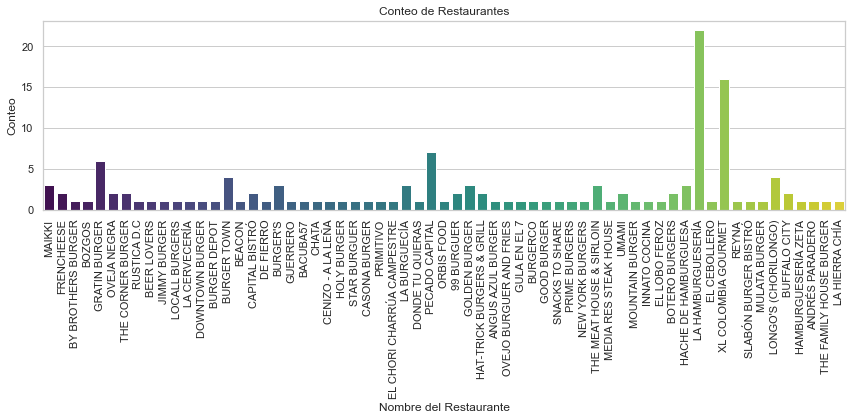

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

## Se acomoda el estilo y el tamaño del gráfico
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6)) 
sns.countplot(x='Restaurante', data=burger_master, palette='viridis')

## Se rotan los nombres de los restaurantes en el eje x
plt.xticks(rotation=90)

plt.xlabel('Nombre del Restaurante')
plt.ylabel('Conteo')
plt.title('Conteo de Restaurantes')

# Muestra el gráfico
plt.tight_layout()
plt.show()

Procedimiento 
1. Se leen y cargan datos
2. identificamos la estructura y tipo de datos disponibles para cada restaurante.
3. Generamos un histograma para mostrar la participación de algunas cadenas de restaurantes.

Análisis y conclusiones
Tenemos una base de datos con el nombre de cada restaurante,  descripción de su hamburguesa y campos de ubicación. La pareja latitud y longitud, así como la cadena de texto con la dirección en el sistema de ubicaciones de Bogotá.
Más allá de los datos de ubicación, se identifican en la base cuatro cadenas de restaurantes con 5 o más ubicaciones, entre ellas La Hamburguesería, XL Gourmet, Pecado Capital y Gratin Burguer.  


### 2.  Visualizando los datos

Visualice la ubicación de cada restaurante en un mapa interactivo. Añada un marcador para cada restaurante y la posibilidad de encontrar la descripción de la hamburguesa ofrecida en un pop-up. (Note que la columna Descripción contiene otra información adicional).

In [7]:
# Utilice este espacio para escribir el código.

import folium
from folium import Popup

latitud_inicial = burger_master['Latitud'].iloc[0]
longitud_inicial = burger_master['Longitud'].iloc[0]

## Se crea un mapa con las coordenadas iniciales
mapa = folium.Map(location=[latitud_inicial, longitud_inicial], zoom_start=12)

for index, row in burger_master.iterrows():
    restaurante = row['Restaurante']
    latitud = row['Latitud']
    longitud = row['Longitud']
    descripcion = row['Descripción']
    
    ## Se hace un marcador en las coordenadas del restaurante y agrega un pop-up con la descripción
    marcador = folium.Marker(location=[latitud, longitud], popup=Popup(restaurante + ': ' + descripcion, parse_html=True))
    marcador.add_to(mapa)

mapa



Procedimiento 
1. Se crea un mapa interativo de Folium.
2. Con un iterador se añade uno a uno los marcadores con los datos del restaurante en el mapa.  

Análisis y Conclusiones
1. Del mapa interactivo se identifica que la mayoría de restaurantes participantes del Burguer Master están sobre el corredor oriental de la ciudad, cercanos a la carrera séptima, muchos se ubican en la localidad de Chapinero. En la zona sur de la ciudad hay muy baja participación de restaurantes.


### 3.  Análisis de puntos calientes

Aplique el modelo de Mezclas Gaussianas para buscar clusters de restaurantes en Bogotá, mencione qué estructura de covarianza usó y explique por qué. Escoja el número óptimo de componentes, explicando el procedimiento y justificando su elección.

In [8]:
# Utilice este espacio para escribir el código.

import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

features = burger_master[['Latitud', 'Longitud']]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)



c:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Window

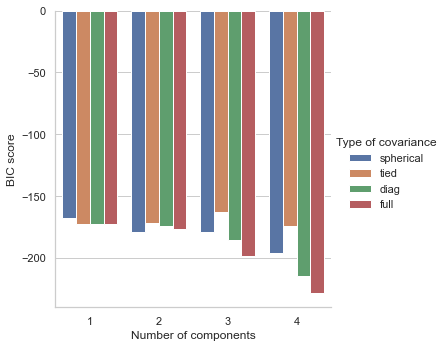

In [13]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV


def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)


param_grid = {
    "n_components": range(1, 5),
    "covariance_type": ["spherical", "tied", "diag", "full"],
}
grid_search = GridSearchCV(
    GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score
)
grid_search.fit(scaled_features)

#------------------------------------------------------------------------------------------------------------------


df_search = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
df_search["mean_test_score"] = df_search["mean_test_score"]
df_search = df_search.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)
df_search.sort_values(by="BIC score").head()


# ----------------------------------------------------------------------
import seaborn as sns

sns.catplot(
    data=df_search,
    kind="bar",
    x="Number of components",
    y="BIC score",
    hue="Type of covariance",
)
plt.show()




In [ ]:


n_components = np.arange(1, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=3).fit(scaled_features)
          for n in n_components]

plt.plot(n_components, [-m.score(scaled_features) for m in models], label='Log-Verosimilitud (neg)')
plt.xlabel('Número de componentes')


n_components = np.arange(1, 20)
models = [GaussianMixture(n, covariance_type='full', random_state=3).fit(Xluna)
          for n in n_components]

plt.plot(n_components, [m.bic(Xluna) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xluna) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('Número de componentes')

Procedimiento 
1. Se estandarizan los datos.
2. Se implementa el modelo de mezclas Gaussianas con una covarianza "completa".
3. Se determinó el número óptimo de componentes a través de xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

Análisis y Conclusiones
1. Se concluye que usar la covarianza completa es los más apropiado por que xxxxxxxxxxxxxxxxxxxxxx
2. se encuentra que el número óptimo de componentes de este caso es de xxxxxxxxxxxx porque xxxxxxxxx

#### 3.1. Visualización de los resultados

Visualice las densidades estimadas por el  mejor modelo estimado en la sección anterior usando un mapa de calor interactivo, discuta los resultados.

In [8]:
# Utilice este espacio para escribir el código.

(Utilice este espacio para describir el procedimiento, análisis, y conclusiones)

### 4. Comparación con KDE

Estime ahora las densidades usando KDE bivariado de la librería `statsmodels` con el anchos de banda dado por `cv_ml`. Muestre los resultados usando un mapa interactivo. Compare los resultados obtenidos por el "mejor" modelo encontrado via MMG. 

In [1]:
# Utilice este espacio para escribir el código.

#Cargamos la librería
import geopandas as gpd
import statsmodels.api as sm

# Ponemos como datos espaciales
db = gpd.GeoDataFrame(burger_master, geometry = gpd.points_from_xy(burger_master.Longitud, burger_master.Latitud))
db.crs = "EPSG:4326"


burger = db[["Latitud", "Longitud"]]

burger.head()


## Se pone aca el modelo optimo obtenido del punto 3
modelo_gmm_optimo = GaussianMixture(n_components=n_optimo, covariance_type='full', random_state=3)
etiquetas_clusters = modelo_gmm_optimo.fit_predict(features_array)

## Agregar las etiquetas de los clusters a DB'
db['Cluster_GMM'] = etiquetas_clusters

c:\Users\Felipe\anaconda3\envs\Financiero\lib\site-packages\geopandas\_compat.py:152: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  set_use_pygeos()
C:\Users\Felipe\AppData\Local\Temp\ipykernel_5820\1758356790.py:4: DeprecationWarning: GeoPandas is set to use PyGEOS over Shapely. PyGEOS support is deprecatedand will be removed in GeoPandas 1.0, released in the Q1 of 2024. Please migrate to Shapely 2.0 (https://geopandas.org/en/stable/docs/user_guide/pygeos_to_shapely.html).
  import geopandas as gpd


NameError: name 'burger_master' is not defined

In [ ]:
import pandas as pd
import numpy as np
import folium
from folium import plugins
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture



bandwidths = np.arange(0.1, 5.0, 0.1)  
kde_cv_ml = sm.nonparametric.KDEMultivariate(burger, var_type='cc', bw='cv_ml')


densities_kde_cv_ml = kde_cv_ml.pdf(burger)
db['Density_KDE_CV_ML'] = densities_kde_cv_ml

mapa_interactivo = folium.Map(location=[db['Latitud'].mean(), db['Longitud'].mean()], zoom_start=12)


for index, row in db.iterrows():
    latitud = row['Latitud']
    longitud = row['Longitud']
    densidad_kde_cv_ml = row['Density_KDE_CV_ML']
    cluster_gmm = row['Cluster_GMM']
    
    
    popup_text = f"Densidad KDE (cv_ml): {densidad_kde_cv_ml:.4f}<br>Cluster GMM: {cluster_gmm}"
    
    
    marker = folium.Marker(location=[latitud, longitud], popup=folium.Popup(popup_text, parse_html=True))
    marker.add_to(mapa_interactivo)


heat_data_kde_cv_ml = [[row['Latitud'], row['Longitud'], row['Density_KDE_CV_ML']] for index, row in db.iterrows()]
plugins.HeatMap(heat_data_kde_cv_ml).add_to(mapa_interactivo)

(Utilice este espacio para describir el procedimiento, análisis, y conclusiones)